In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Download data from Goolge Drive

In [2]:
import gdown
import zipfile

In [3]:
url = "https://drive.google.com/file/d/1RTyqSiDB_07cs7cRYrBZeb7NJpwFPhup/view?usp=sharing"

In [4]:
file_id = url.split("/")[-2]
file_id

'1RTyqSiDB_07cs7cRYrBZeb7NJpwFPhup'

In [5]:
prefix = 'https://drive.google.com/uc?/export=download&id='
gdown.download(prefix + file_id, 'garbage.zip')

Downloading...
From (original): https://drive.google.com/uc?/export=download&id=1RTyqSiDB_07cs7cRYrBZeb7NJpwFPhup
From (redirected): https://drive.google.com/uc?%2Fexport=download&id=1RTyqSiDB_07cs7cRYrBZeb7NJpwFPhup&confirm=t&uuid=6ebdca37-ce08-483e-abdb-7a5830a49f85
To: /content/garbage.zip
100%|██████████| 251M/251M [00:07<00:00, 34.3MB/s]


'garbage.zip'

In [6]:
zip_path = "/content/garbage.zip"
extract_path = ""

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")

Extraction complete!


# Importing necessary libraries

In [7]:
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
# import cv2
# import imghdr
import tensorflow as tf
from tensorflow.keras import models, layers, Sequential
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Data Cleaning

In [8]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

base_dir = "garbage"

def check_image_formats(base_dir, valid_exts):
    all_images_valid = True
    invalid_images = []

    for sub_dir in os.listdir(base_dir):
        sub_dir_path = os.path.join(base_dir, sub_dir)
        if not os.path.isdir(sub_dir_path):
            continue

        for file_name in os.listdir(sub_dir_path):
            file_path = os.path.join(sub_dir_path, file_name)

            if os.path.isdir(file_path):
                continue

            file_ext = file_name.split('.')[-1].lower()
            if file_ext not in valid_exts:
                all_images_valid = False
                invalid_images.append(file_path)

    if all_images_valid:
        print("All images are in the specified formats.")
    else:
        print("The following images are not in the specified formats:")
        for img in invalid_images:
            print(img)

check_image_formats(base_dir, image_exts)


All images are in the specified formats.


In [9]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "garbage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 15515 files belonging to 12 classes.


In [11]:
class_names = dataset.class_names
class_names

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

In [12]:
len(dataset)
485*32

15520

# Basic EDA

In [13]:
data_dir = "garbage"
name = []
length = []
# len_list = []
for i in os.listdir(data_dir):
  file_path = os.path.join(data_dir,i)
  name.append(i)
  length.append(len(os.listdir(file_path)))

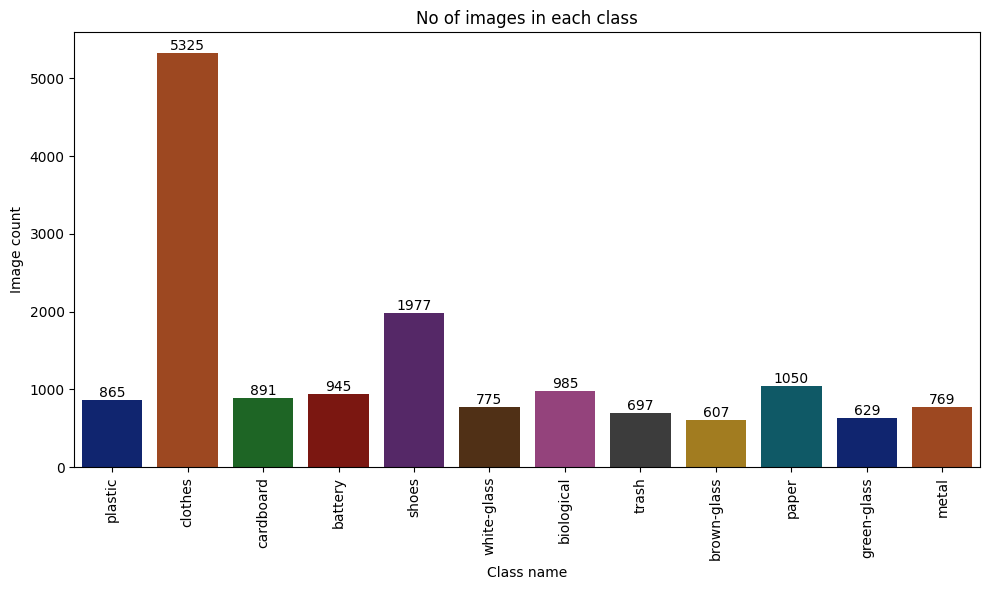

In [14]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=name,y=length,palette='dark')
for i in ax.containers:
  ax.bar_label(i)
plt.title("No of images in each class")
plt.xlabel("Class name")
plt.ylabel("Image count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

##### from the above plot we can clearly see data is imblanced.

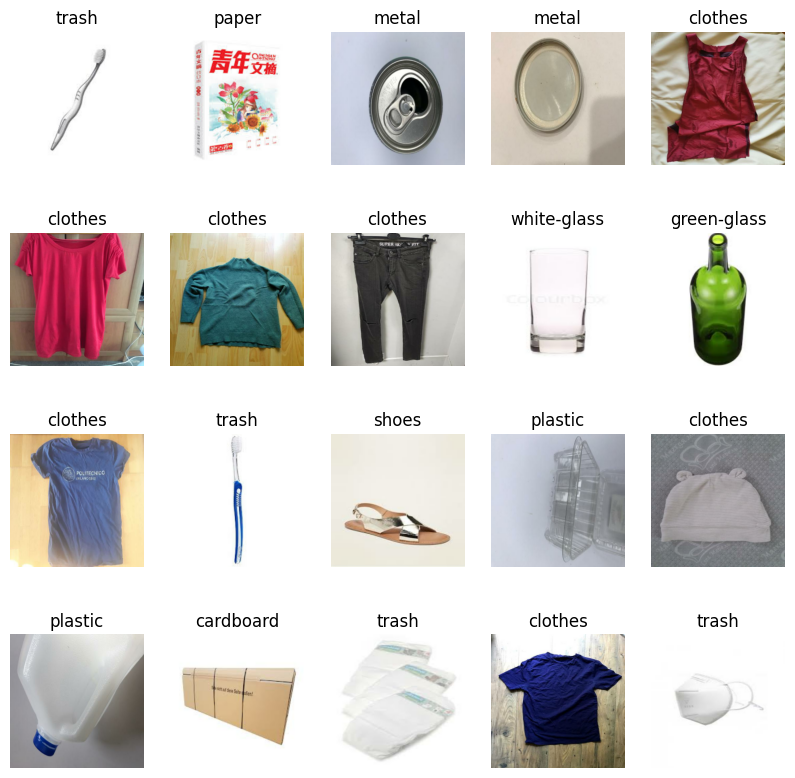

In [15]:
plt.figure(figsize=(10,10))

for img_batch, label in dataset.take(1):
  for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(img_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label[i]])
    plt.axis("off")

In [16]:
# len(dataset) * 0.80

In [17]:
# train_ds = dataset.take(388)
# len(train_ds)

In [18]:
# test_ds = dataset.skip(388)
# len(test_ds)

In [19]:
# val_size = 0.1
# len(dataset) * val_size

In [20]:
# val_ds = test_ds.take(48)
# len(val_ds)

In [21]:
# test_ds = test_ds.skip(48)
# len(test_ds)

# Split the data

In [22]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  assert (train_split + test_split + val_split) == 1
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [23]:
train_ds, val_ds, test_ds = split_dataset(dataset)

In [24]:
print(f"training data : {len(train_ds)}")
print(f"validation data : {len(val_ds)}")
print(f"testing data : {len(test_ds)}")

training data : 388
validation data : 48
testing data : 49


In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Preprocessing

In [26]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])


In [27]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
from tensorflow.keras import layers, models

IMAGE_SIZE = 256
CHANNELS = 3
n_classes = 12

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Define the model
model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),  # Explicitly define the input shape
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))


In [31]:
# n_classes = 12
# input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# model = models.Sequential()

# model.add(Input(shape=input_shape))
# model.add(resize_and_rescale)
# model.add(data_augmentation)

# model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
# model.add(layers.MaxPooling2D((2,2)))

# model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
# model.add(layers.MaxPooling2D((2,2)))

# model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
# model.add(layers.MaxPooling2D((2,2)))

# model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
# model.add(layers.MaxPooling2D((2,2)))

# model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
# model.add(layers.MaxPooling2D((2,2)))

# model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
# model.add(layers.MaxPooling2D((2,2)))

# model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
# model.add(layers.MaxPooling2D((2,2)))

# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(n_classes, activation='softmax'))


In [32]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 26, 26, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 22, 22, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 20, 20, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 18, 18, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,327,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,605,836 (6.13 MB)

 Trainable params: 1,605,836 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],


)

In [34]:
callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=2,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [35]:
# model.fit(
#     train_ds,
#     epochs=30,
#     batch_size = BATCH_SIZE,
#     verbose = 1,
#     validation_data=val_ds,
#     callbacks=callback
# )